# Installing the dataset from kaggle


In [ ]:
!pwd

/content


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:19<00:00, 56.2MB/s]
100% 1.33G/1.33G [00:19<00:00, 74.4MB/s]


In [ ]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.8 MB/s eta 0:00:00


# Importing libraries plus unzipping the dataset

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
!unzip celeba-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

# Importing first 500 images and normalizing it

So this section was quite interesting to play. At first I just took all the images of the dataset and literally colab died. My RAM was as high as 12 GB. Then I tried decreasing the size so I brought it down to I guess 50000 images and it was still taking some 10 minutes per epoch(total epochs were 50). I trained my model whole night and got some not so good but not so bad results. It took nearly 7 hours to train. So I decreased the size further to 500 images. Now training time was reduced to 40 secs. I got similar results so that was an achievement. 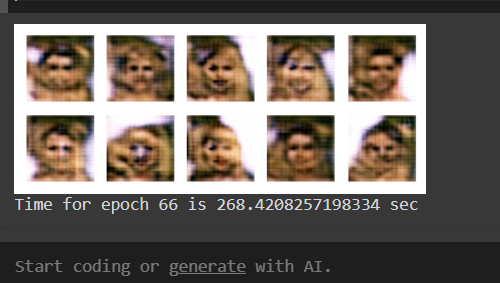 This was when I trained with 50k images.
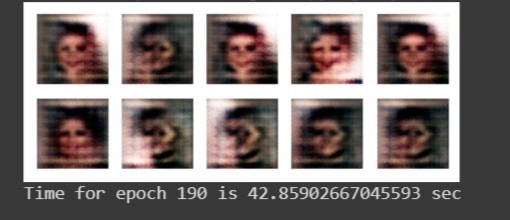 This was at 500 images before changing other parameters.

Also I played with batch size a lot too. Earlier it was 256 which I shamelessly copied from mnist tf implementation. But It was not working. I tried to decrease it. Changed it couple of times and got to know that 32 to 64 is good range for the model.

In [ ]:
all_image_path = []
full_image_train_path = '/content/img_align_celeba/img_align_celeba'
for path in os.listdir(full_image_train_path):
  if '.jpg' in path:
    all_image_path.append(os.path.join(full_image_train_path, path))
image_path_50k = all_image_path[0:500]
len(image_path_50k)

500

In [ ]:
from PIL import Image
training_images = [np.array((Image.open(path)).resize((64,64))) for path in image_path_50k]

In [ ]:
for i in range(len(training_images)):
  training_images[i] = tf.cast(training_images[i], tf.float32)
  training_images[i] = (training_images[i] / 127.5) - 1.0
  #training_images[i] = ((training_images[i] - training_images[i].min())/(255 - training_images[i].min()))

training_images = np.array(training_images)

In [ ]:
buffer_size = 100
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(training_images).shuffle(buffer_size).batch(batch_size)

# Defining generator model for both versions

I didn't try increasing or decreasing layers a lot but I played with kernels, strides and channels a lot. It wasn't changing the output by huge difference but was changing the time/epoch.
I tried increasing transpose conv layers till 5 but imo it was't worth it cuz it was taking more time with not so better output. So I kept it 4 and 3 only.
Also I tried randomly relu plus dropout but didn't work out.
 
There are two versions here. V1 is with less conv layers(3) and V2 with more(4). Although Discriminator is same for both the versions

In [ ]:
def make_generator_model_v1():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)) # 3 deconvolution layers implemented. 
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3) #matching the size with input image
    return model

In [ ]:
def make_generator_model_v2():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)) # 4 deconvolution layers implemented
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

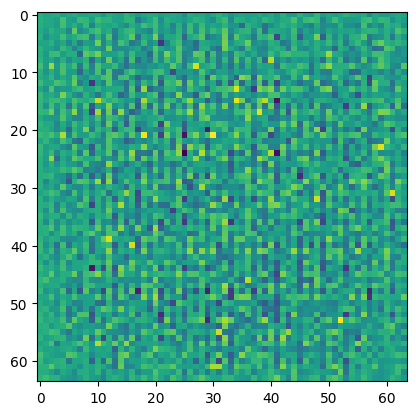

In [ ]:
generator_v1 = make_generator_model_v1()
generator_v2 = make_generator_model_v2()

noise = tf.random.normal([1, 100])
generated_image = generator_v2(noise, training=False) #testing the generator

plt.imshow(generated_image[0, :, :, 0])

# Defining Discriminator model

I didn't play with Discriminator a lot. Also it's same for both the versions.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3])) # not changed it a lot. Mostly same as MNIST implementation
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator_v1 = make_discriminator_model()
discriminator_v2 = make_discriminator_model()

decision = discriminator_v1(generated_image)
print (decision)

tf.Tensor([[0.00122523]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Defining both losses and adam optimizer

This was the most fun section to play with. First I put my both learning rate to be 1e-4. At this lr Discriminator was overpowering the generator. So I tried doubling LR of Generator but then generator was overpowering the discriminator. Then I divided both by 10. It was sort of working but model wa not converging and most of the times generator was overpowering Discriminator. I did try with 1.5* but was still not working. Then I looked up for the soultion on stack exchange and tried implementing beta in it. It is working rn.

In [ ]:
def discloss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    totaloss = real_loss + fake_loss
    return totaloss

In [ ]:
def genloss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
genoptimizerv1 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
genoptimizerv2 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discoptimizerv1 = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discoptimizerv2 = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

# Writing checkpoints for saving images

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer_v1=genoptimizerv1,
    discriminator_optimizer_v1=discoptimizerv1,
    generator_v1=generator_v1,
    discriminator_v1=discriminator_v1,
    generator_optimizer_v2=genoptimizerv2,
    discriminator_optimizer_v2=discoptimizerv2,
    generator_v2=generator_v2,
    discriminator_v2=discriminator_v2
)

# Defining epochs and training function

At first I defined epochs to be as high as 1000. But image was hardly changing after 150-200 epochs. Also the losses would first converge to some value till I guess not more 100 eopchs then after that it will vary a lot. Too much random variation. Image would suddenly go black and then retrieve back to same state. So I decreased my epochs too. But when I decreased my input to 500 and also decreased the learning rates then It was taking time to converge or I should say generating a more rigid image. So for now my epochs are 150.

In [ ]:
EPOCHS = 150 # I trained repetitively at 150 epochs thats why in plot below you will see 450 epochs 
noise_dim = 100
num_examples_to_generate = 10
'''genoptimizerv1.build(generator_v1.trainable_variables)
discoptimizerv1.build(discriminator_v1.trainable_variables) 
genoptimizerv2.build(generator_v2.trainable_variables)
discoptimizerv2.build(discriminator_v2.trainable_variables)'''

all_trainable_variables = generator_v1.trainable_variables + discriminator_v1.trainable_variables + \
                          generator_v2.trainable_variables + discriminator_v2.trainable_variables

genoptimizerv1.build(all_trainable_variables) 
discoptimizerv1.build(all_trainable_variables)
genoptimizerv2.build(all_trainable_variables)
discoptimizerv2.build(all_trainable_variables)

#seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
gen_loss_history_v1 = [] # maintains all the losses of both the versions.
gen_loss_history_v2 = []
disc_loss_history_v1 = []
disc_loss_history_v2 = []
combined_loss_history_v1 = []
combined_loss_history_v2 = []
@tf.function
def train_step(images):
    noise_v1 = tf.random.normal([batch_size, noise_dim]) #training from noise
    noise_v2 = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape_v1, tf.GradientTape() as gen_tape_v2, tf.GradientTape() as disc_tape_v1, tf.GradientTape() as disc_tape_v2:
      #generated_images = generator(noise, training=True)
      generated_images_v1 = generator_v1(noise_v1, training=True) #generating images from noise
      generated_images_v2 = generator_v2(noise_v2, training=True)

      real_output_v1 = discriminator_v1(images, training=True) 
      fake_output_v1 = discriminator_v1(generated_images_v1, training=True)
      real_output_v2 = discriminator_v2(images, training=True)
      fake_output_v2 = discriminator_v2(generated_images_v2, training=True)

      gen_loss_v1 = genloss(fake_output_v1)
      disc_loss_v1 = discloss(real_output_v1, fake_output_v1)
      gen_loss_v2 = genloss(fake_output_v2)
      disc_loss_v2 = discloss(real_output_v2, fake_output_v2)

      total_loss_v1 = gen_loss_v1 + disc_loss_v1
      total_loss_v2 = gen_loss_v2 + disc_loss_v2

    gradients_of_generator_v1 = gen_tape_v1.gradient(gen_loss_v1, generator_v1.trainable_variables)
    gradients_of_discriminator_v1 = disc_tape_v1.gradient(disc_loss_v1, discriminator_v1.trainable_variables)

    gradients_of_generator_v2 = gen_tape_v2.gradient(gen_loss_v2, generator_v2.trainable_variables)
    gradients_of_discriminator_v2 = disc_tape_v2.gradient(disc_loss_v2, discriminator_v2.trainable_variables)

    genoptimizerv1.apply_gradients(zip(gradients_of_generator_v1, generator_v1.trainable_variables))
    discoptimizerv1.apply_gradients(zip(gradients_of_discriminator_v1, discriminator_v1.trainable_variables))

    genoptimizerv2.apply_gradients(zip(gradients_of_generator_v2, generator_v2.trainable_variables))
    discoptimizerv2.apply_gradients(zip(gradients_of_discriminator_v2, discriminator_v2.trainable_variables))

    return gen_loss_v1, disc_loss_v1, total_loss_v1, gen_loss_v2, disc_loss_v2, total_loss_v2

In [ ]:
min_total_error_v1 = float('inf')# for calculating minimum total loss to find best image 
min_total_error_v2 = float('inf')
min_loss_epoch_v1 = -1
min_loss_epoch_v2 = -1

seed_v1 = tf.random.normal([num_examples_to_generate, noise_dim])
seed_v2 = tf.random.normal([num_examples_to_generate, noise_dim])
def train(dataset, epochs):

  global min_total_error_v1, min_loss_epoch_v1, min_total_error_v2, min_loss_epoch_v2

  for epoch in range(epochs):
    start = time.time()
    gen_loss_epoch_v1 = []
    disc_loss_epoch_v1 = []
    total_loss_epoch_v1 = []
    gen_loss_epoch_v2 = []
    disc_loss_epoch_v2 = []
    total_loss_epoch_v2 = []

    for image_batch in dataset:
      gen_loss_v1, disc_loss_v1, total_loss_v1, gen_loss_v2, disc_loss_v2, total_loss_v2 = train_step(image_batch)
      gen_loss_epoch_v1.append(gen_loss_v1) # appends the losses on list whose mean will be used to plot the curve vs epochs
      disc_loss_epoch_v1.append(disc_loss_v1)
      total_loss_epoch_v1.append(total_loss_v1)
      gen_loss_epoch_v2.append(gen_loss_v2)
      disc_loss_epoch_v2.append(disc_loss_v2)
      total_loss_epoch_v2.append(total_loss_v2)

    gen_loss_history_v1.append(np.mean(gen_loss_epoch_v1))
    disc_loss_history_v1.append(np.mean(disc_loss_epoch_v1))
    combined_loss_history_v1.append(np.mean(total_loss_epoch_v1))
    gen_loss_history_v2.append(np.mean(gen_loss_epoch_v2))
    disc_loss_history_v2.append(np.mean(disc_loss_epoch_v2))
    combined_loss_history_v2.append(np.mean(total_loss_epoch_v2))

    #print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss_history[-1]}, Disc Loss: {disc_loss_history[-1]}, Total Loss: {combined_loss_history[-1]}')
    display.clear_output(wait=True)
    generate_and_save_images(generator_v1, epochs, seed_v1, 'v1') # saving the images 
    generate_and_save_images(generator_v2, epochs, seed_v2, 'v2')
    if combined_loss_history_v1[-1] < min_total_error_v1: 
      min_total_error_v1 = combined_loss_history_v1[-1] # for calculating minimum loss
      min_loss_epoch_v1 = epoch + 1

    if combined_loss_history_v2[-1] < min_total_error_v2:
      min_total_error_v2 = combined_loss_history_v2[-1]
      min_loss_epoch_v2 = epoch + 1

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    plot_losses(gen_loss_history_v1, disc_loss_history_v1, combined_loss_history_v1, version='v1') # plots the curves live while training
    plot_losses(gen_loss_history_v2, disc_loss_history_v2, combined_loss_history_v2, version='v2')

  plot_losses(gen_loss_history_v1, disc_loss_history_v1, combined_loss_history_v1, version='v1') # plots the curve after training
  plot_losses(gen_loss_history_v2, disc_loss_history_v2, combined_loss_history_v2, version='v2')


  display.clear_output(wait=True)
  #generate_and_save_images(generator,epochs,seed)
  generate_and_save_images(generator_v1, epochs, seed_v1, 'v1')
  generate_and_save_images(generator_v2, epochs, seed_v2, 'v2')

# Defining ploting losses and generating image function

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(gen_losses, disc_losses, combined_losses, version='v1'):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label=f'Generator Loss ({version})')
    plt.plot(disc_losses, label=f'Discriminator Loss ({version})')
    plt.plot(combined_losses, label=f'Combined Loss ({version})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Losses ({version})')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def generate_and_save_images(model, epoch, test_input, version):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}_{version}.png')
    plt.show()

# TRAINING THE MODEL

The results I was getting at 180 epochs were the best I guess. After that model went random. I mean few few faces were good in the structure but most of them were random. Here is the one I got at around 150 epochs: 
![Screenshot 2024-06-18 095423.png](<attachment:Screenshot 2024-06-18 095423.png>) 

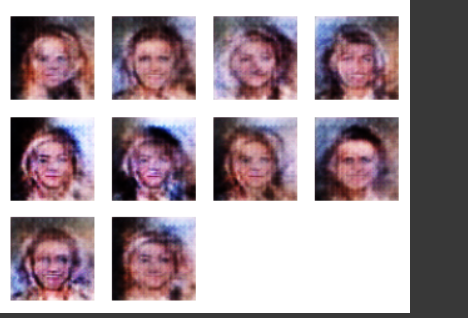

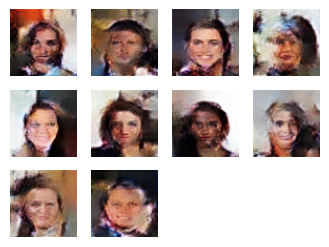

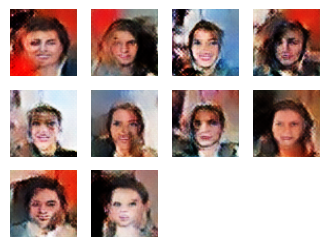

Time for epoch 28 is 73.8352587223053 sec


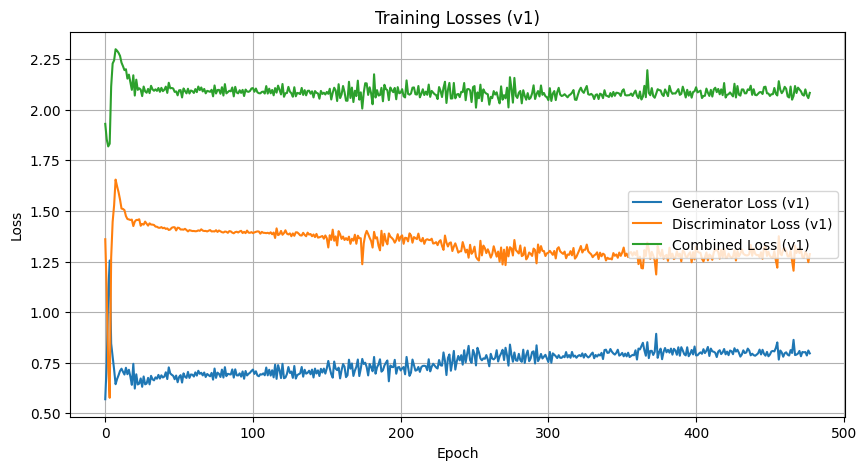

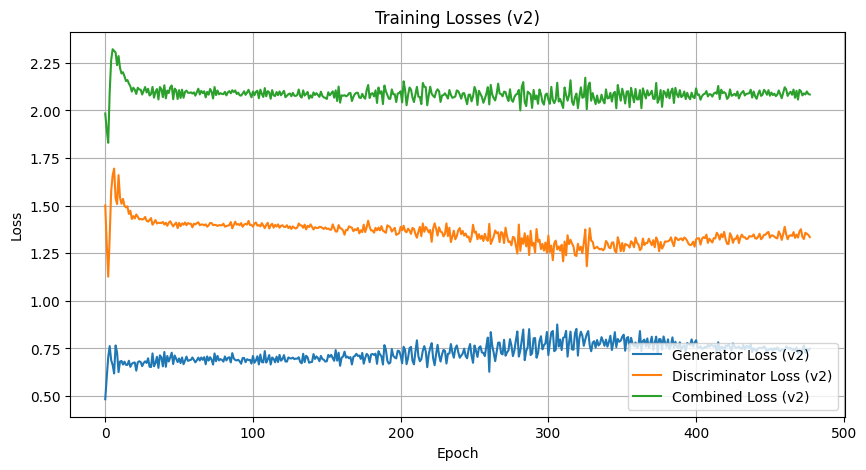

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
plot_losses(gen_loss_history_v1, disc_loss_history_v1, combined_loss_history_v1, version='v1')
plot_losses(gen_loss_history_v2, disc_loss_history_v2, combined_loss_history_v2, version='v2')
# was not able to plot it cuz runtime used to get disconnected everytime.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image with the lowest loss
image_dir = '/content'
os.makedirs(image_dir, exist_ok=True)

image_path = os.path.join(image_dir, f'image_at_epoch_{min_loss_epoch:04d}.png')
#image_path = 'content/image_at_epoch_{min_loss_epoch:04d}.png'
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f'Image with Lowest Error at Epoch {min_loss_epoch}')
plt.show()
# was not able to plot it cuz runtime used to get disconnected everytime. I got it at 150 epochs but after that after training nothing was able to run.

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-32-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-32-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



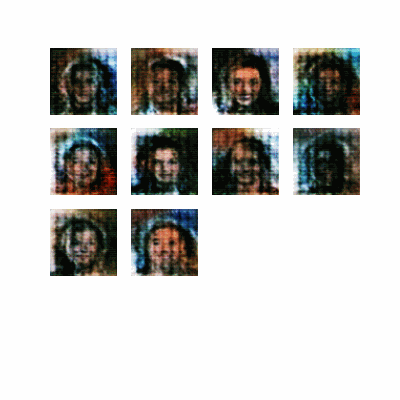

In [33]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file) # this is gif file. The gif currently showing up is for epochs 300. I was not able to run afterwards because of above mentioned reason

In [ ]:
!pip install tensorflow_docs